# Test the One-Class SVM algorithm

In [1079]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1080]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import util
import importlib
import pywt

importlib.reload(util)

<module 'util' from '/Users/stan/Desktop/UCU/linear-algebra/course-project/util.py'>

Prototyping of the intrusion detection system, based on the BCCC-CIC-IDS-2017 dataset.

In [1081]:
# Load the data

# data = util.read_all_files()

data = util.read_files(['friday_benign.csv', 'ddos_loit.csv'])

data['timestamp'] = pd.to_datetime(data['timestamp'], format='mixed')
data = data.set_index('timestamp')
data = data.sort_index()

# Detection

In [1107]:
normal_traffic_df = data.loc['2017-07-07']

normal_traffic_df

,flow_id,src_ip,src_port,dst_ip,dst_port,protocol,duration,packets_count,fwd_packets_count,bwd_packets_count,...,bwd_packets_IAT_mean,bwd_packets_IAT_std,bwd_packets_IAT_max,bwd_packets_IAT_min,bwd_packets_IAT_total,subflow_fwd_packets,subflow_bwd_packets,subflow_fwd_bytes,subflow_bwd_bytes,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-07-07 07:59:50.315195,192.168.10.50_56108_192.168.10.3_3268_TCP_2017...,192.168.10.50,56108,192.168.10.3,3268,TCP,728.909637,366,239,127,...,5.784995e+00,7.357051,1.643023e+01,1.907349e-06,7.289094e+02,4.425926,2.351852,855.814815,855.814815,Benign
2017-07-07 07:59:50.316273,192.168.10.50_42144_192.168.10.3_389_TCP_2017-...,192.168.10.50,42144,192.168.10.3,389,TCP,696.908053,321,214,107,...,6.574602e+00,7.437127,1.640696e+01,9.536743e-07,6.969078e+02,4.037736,2.018868,800.641509,800.641509,Benign
2017-07-07 08:00:34.845380,192.168.10.9_63210_224.0.0.252_5355_UDP_2017-0...,192.168.10.9,63210,224.0.0.252,5355,UDP,0.100126,22,22,0,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,Benign
2017-07-07 08:00:35.164943,192.168.10.9_137_192.168.10.3_137_UDP_2017-07-...,192.168.10.9,137,192.168.10.3,137,UDP,93.069427,40,20,20,...,4.898379e+00,12.537105,5.076320e+01,2.861023e-06,9.306920e+01,2.500000,2.500000,147.500000,147.500000,Benign
2017-07-07 08:00:35.215632,192.168.10.9_49429_192.168.10.3_53_UDP_2017-07...,192.168.10.9,49429,192.168.10.3,53,UDP,0.000245,4,2,2,...,4.050000e-06,0.000000,4.053116e-06,4.053116e-06,4.053116e-06,0.000000,0.000000,0.000000,0.000000,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-07 16:02:39.565876,192.168.10.50_22_192.168.10.17_37758_TCP_2017-...,192.168.10.50,22,192.168.10.17,37758,TCP,0.000085,3,0,3,...,4.244000e-05,0.000005,4.792213e-05,3.695488e-05,8.487701e-05,0.000000,0.000000,0.000000,0.000000,Benign
2017-07-07 16:02:39.567285,192.168.10.17_37759_192.168.10.50_22_TCP_2017-...,192.168.10.17,37759,192.168.10.50,22,TCP,1.238502,85,42,43,...,2.948541e-02,0.145225,9.538362e-01,9.536743e-07,1.238387e+00,0.000000,0.000000,0.000000,0.000000,Benign
2017-07-07 16:02:40.805791,192.168.10.50_22_192.168.10.17_37759_TCP_2017-...,192.168.10.50,22,192.168.10.17,37759,TCP,0.000081,3,0,3,...,4.053000e-05,0.000008,4.887581e-05,3.218651e-05,8.106232e-05,0.000000,0.000000,0.000000,0.000000,Benign


In [1108]:
normal_internal = normal_traffic_df[normal_traffic_df['dst_ip'].str.contains('192.168')]

normal_internal_resampled, normal_internal_resampled_label = util.resample(normal_internal, '1s')

normal_internal_resampled

,avg_bwd_bulk_rate,packets_IAT_mean
timestamp,,
2017-07-07 07:59:50,0.000000,2.087425e+00
2017-07-07 07:59:51,76477.337892,9.872785e+06
2017-07-07 07:59:52,152954.675783,1.974557e+07
2017-07-07 07:59:53,229432.013675,2.961835e+07
2017-07-07 07:59:54,305909.351567,3.949113e+07
...,...,...
2017-07-07 16:02:37,0.000000,1.499458e+09
2017-07-07 16:02:38,28124.122295,5.982232e-03
2017-07-07 16:02:39,55502.048995,7.393255e-03


In [1109]:
normal_internal_resampled_label.value_counts()

label
 1    27889
-1     1083
Name: count, dtype: int64

[[ 1.72803993e+08  1.72803993e+08]
 [-5.18872181e+07 -5.18872181e+07]
 [ 6.42038239e+07  6.42038239e+07]
 ...
 [ 9.26367595e+08  9.26367595e+08]
 [ 8.67492944e+08  8.67492944e+08]
 [ 5.91830858e+08  5.91830858e+08]]


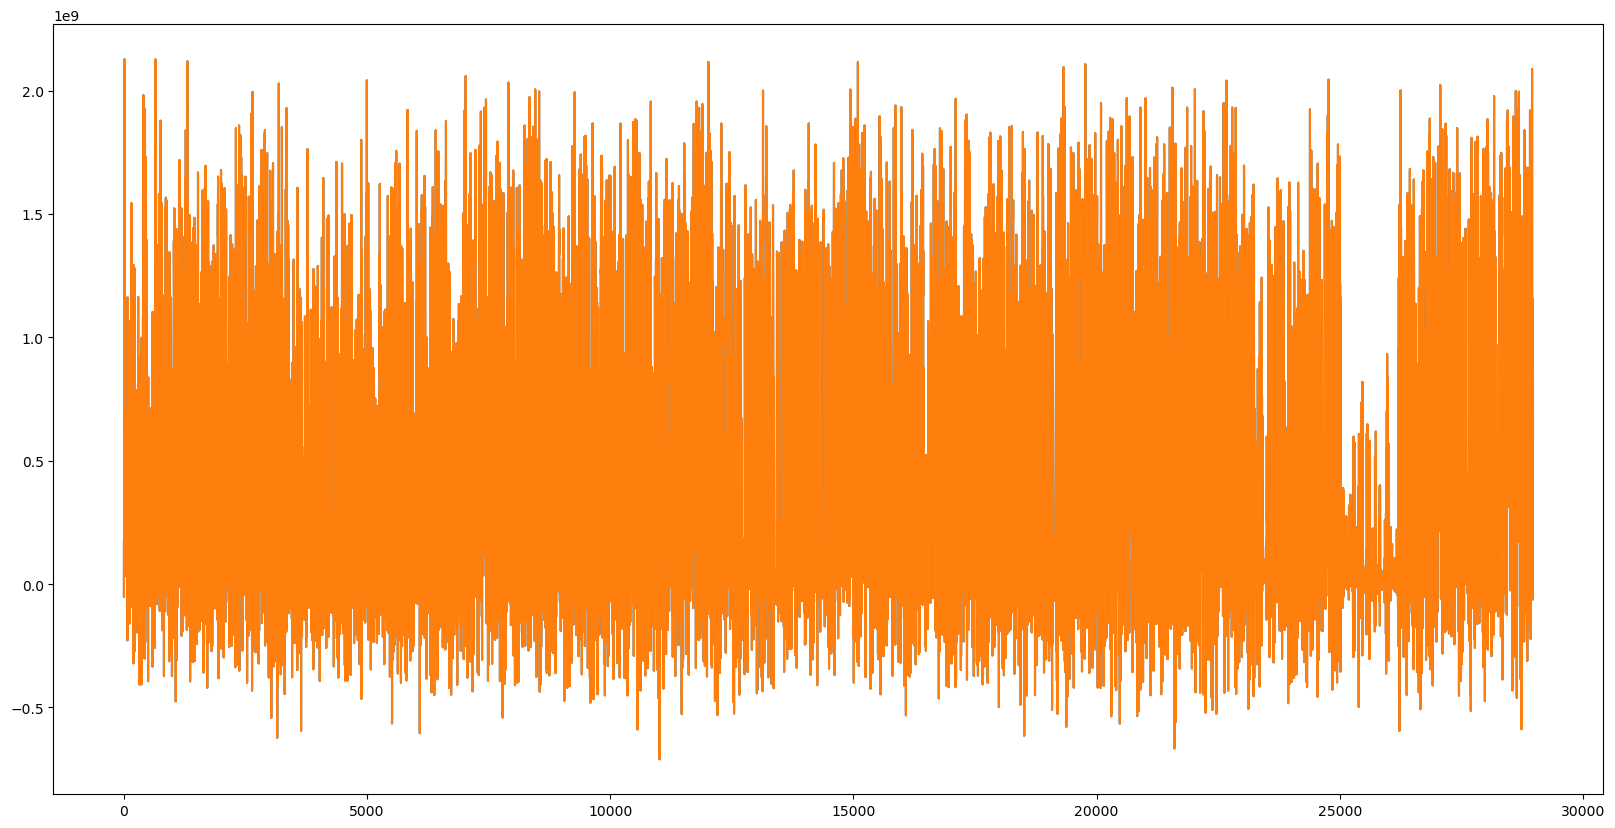

In [ ]:

if len(normal_internal_resampled) % 2 != 0:
    normal_internal_resampled = normal_internal_resampled[:-1]
    normal_internal_resampled_label = normal_internal_resampled_label[:-1]
    
coefs = pywt.swtn(normal_internal_resampled, 'db28', level=1)

# print(coefs[0]['aa'])

plt.figure(figsize=(20, 10))
# plt.plot(coefs[0]['ad'])
plt.plot(coefs[0]['aa'])
plt.show()



In [1111]:
dwt_df

,src_ip_approx,src_ip_detail,dst_ip_approx,dst_ip_detail,udp_count_approx,udp_count_detail,tcp_count_approx,tcp_count_detail,duration_approx,duration_detail,...,dst_port_category_dynamic_approx,dst_port_category_dynamic_detail,dst_port_category_registered_approx,dst_port_category_registered_detail,dst_port_category_remote_access_approx,dst_port_category_remote_access_detail,dst_port_category_web_approx,dst_port_category_web_detail,dst_port_category_well_known_approx,dst_port_category_well_known_detail
0,2.841729,0.002482,2.513862,0.000861,7.776320,0.006207,-0.070889,0.000455,3.992806,0.899552,...,-0.032023,0.000564,0.034158,0.002058,0.017087,0.001837,-0.084992,0.000727,1.885701,-0.004729
1,2.396251,-0.004609,2.096027,-0.004053,6.449384,-0.003727,-0.150246,-0.009282,-3.630551,-1.769635,...,-0.135157,-0.000504,0.091907,-0.003062,-0.040264,-0.000926,-0.009620,-0.000250,1.202927,-0.005339
2,1.986185,-0.001712,1.759295,-0.000920,4.340955,-0.003403,0.414758,-0.001700,-7.794794,-0.801226,...,0.312860,-0.000350,0.087020,-0.001229,-0.034059,-0.000914,0.041153,-0.000355,0.651244,0.000964
3,1.663448,0.001460,1.559667,0.001414,2.214136,0.000645,0.924685,0.003415,9.725849,0.541255,...,0.558542,0.000094,0.161582,0.001072,0.075301,0.000117,0.028999,0.000021,0.394568,0.002345
4,0.441871,0.000843,0.552031,0.000536,0.121412,0.001404,-0.080212,0.001222,11.852437,0.441898,...,-0.009172,0.000147,-0.034062,0.000615,0.042936,0.000338,-0.052765,0.000137,0.000208,0.000101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28967,0.501436,0.053834,1.108366,0.042365,-0.807507,0.057595,2.645706,0.077787,-0.886220,14.069041,...,1.658029,0.007425,0.520312,0.034932,-0.005876,0.018630,-0.048986,0.005141,0.527588,0.018506
28968,-0.843550,-0.007075,0.312788,-0.010084,-1.906156,0.002478,1.234923,-0.026641,-0.695541,-3.584972,...,0.740748,-0.001485,0.159643,0.001359,-0.010321,0.001245,-0.147942,0.001349,-0.330711,-0.033628
28969,-0.883157,-0.027539,0.035103,-0.022111,0.537088,-0.029184,0.080465,-0.043592,-1.809021,-8.495715,...,-0.089601,-0.003896,0.098220,-0.017210,-0.029403,-0.008855,-0.163716,-0.002433,-0.341393,-0.015401
28970,0.589474,-0.001162,0.857115,0.001434,4.435405,-0.007675,-0.068072,0.006483,-4.324546,0.122435,...,-0.017770,-0.000329,0.054473,-0.002604,-0.039993,-0.002530,-0.149138,-0.001164,0.748628,0.014242


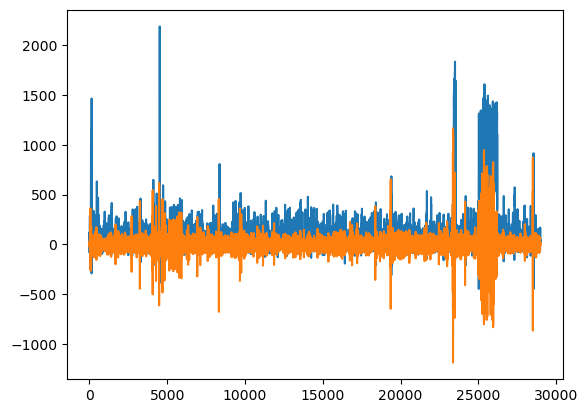

In [1112]:
plt.plot(dwt_df[['payload_bytes_mean_approx', 'payload_bytes_mean_detail']])

In [1113]:
# load the model
import pickle

with open('one_class_svm_mon.sav', 'rb') as f:
    clf = pickle.load(f)

In [1114]:
# predict the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(dwt_df)

y_pred = clf.predict(X)

ValueError: X has 82 features, but OneClassSVM is expecting 36 features as input.

In [1057]:
# printy_pred[y_pred == 1]

print(len(y_pred))
print(len(y_pred[y_pred == -1]))

28972
5796


In [1058]:
labels_df = normal_internal_resampled_label

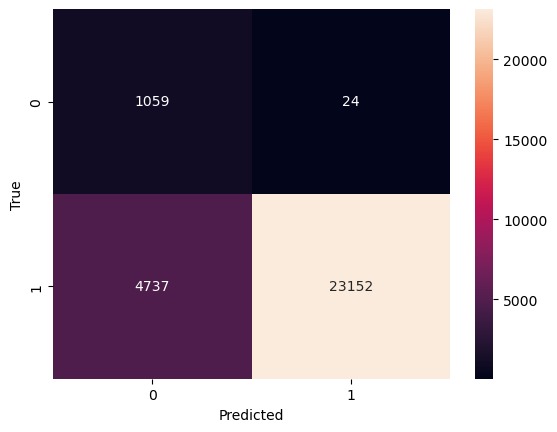

              precision    recall  f1-score   support

          -1       0.18      0.98      0.31      1083
           1       1.00      0.83      0.91     27889

    accuracy                           0.84     28972
   macro avg       0.59      0.90      0.61     28972
weighted avg       0.97      0.84      0.88     28972

(array([0.18271222, 0.99896445]), array([0.97783934, 0.83014809]), array([0.30789359, 0.90676589]), array([ 1083, 27889]))


In [ ]:
# classification report
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

sns.heatmap(confusion_matrix(labels_df, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(labels_df, y_pred))

report = precision_recall_fscore_support(labels_df, y_pred)

print(report)

In [1060]:
# load the model
import pickle

with open('isolation_forest_mon.sav', 'rb') as f:
    isolation_forest_clf = pickle.load(f)

In [ ]:
# predict the data

y_pred = isolation_forest_clf.predict(X)

# printy_pred[y_pred == 1]

print(len(y_pred))
print(len(y_pred[y_pred == -1]))

28972
1222


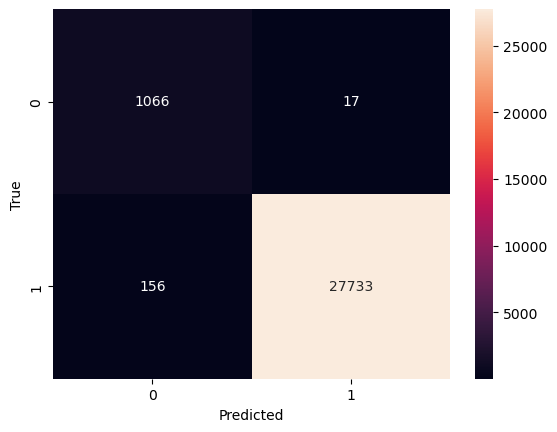

              precision    recall  f1-score   support

          -1       0.87      0.98      0.92      1083
           1       1.00      0.99      1.00     27889

    accuracy                           0.99     28972
   macro avg       0.94      0.99      0.96     28972
weighted avg       0.99      0.99      0.99     28972

(array([0.87234043, 0.99938739]), array([0.98430286, 0.9944064 ]), array([0.92494577, 0.99689067]), array([ 1083, 27889]))


In [1062]:
sns.heatmap(confusion_matrix(labels_df, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(labels_df, y_pred))

report = precision_recall_fscore_support(labels_df, y_pred)

print(report)